# AstroLogics Tutorial, Boolean Network Analysis and Clustering : Herault Hematopoiesis

This tutorial demonstrates the AstroLogics framework for analyzing and comparing Boolean network model ensembles. AstroLogics is designed for benchmarking Boolean models through three major evaluation criteria: network evaluation, logical function evaluation, and dynamic evaluation.

## Overview of AstroLogics Framework

AstroLogics addresses a critical gap in Boolean network modeling: while multiple methods exist for Boolean model synthesis (like Bonesis, BN-sketch), there hasn't been a standardized way to evaluate and compare generated model ensembles. The framework focuses on:

- **Dynamic properties**: Examining state transition graphs and model behaviors through simulation
- **Logical function evaluation**: Analyzing and comparing logical rules that govern node behaviors
- **Model clustering**: Identifying groups of models with similar dynamics and logical features

## Required Libraries

In [1]:
import pandas as pd 
import os
import astrologics as ast
import seaborn as sns
import matplotlib.pyplot as plt

### Dataset: Herault hematopoeisis model

We'll use the Herault Hematopoiesis model from Herault et al., 2018, which provides an excellent framework for studying blood cell differentiation. This model contains 33 nodes representing key transcription factors and signaling molecules involved in hematopoietic lineage specification. The model demonstrates hierarchical decision-making processes during blood cell development from hematopoietic stem cells to differentiated blood cell types.

## Step 1: Load Model Ensemble

In [2]:
model_path = 'models/herault_hematopoiesis/'
model = ast.ensemble(model_path, project_name = 'herault_hematopoiesis')
model.create_simulation()

Simulation object created


The `ensemble` object is the core component of AstroLogics that handles:

- Loading multiple Boolean network models from a directory
- Managing simulation parameters and configurations
- Coordinating analysis across the model ensemble

## Step 2: Simulate the model ensemble

In this part of the script we first simulate all the BN within the model ensemble. We utilize the MaBoSS engine as the main simulator.

This creates an initial state where all nodes have equal probability (0.5) of being active. This represents a neutral starting condition that allows the system to evolve according to its inherent dynamics.

We then start the simulation using MaBoSS.

**MaBoSS** (Markovian Boolean Stochastic Simulator) is crucial for the AstroLogics approach because:

- It converts Boolean network dynamics into continuous-time Markov processes
- Provides probabilistic approximation of complex state transition graphs
- Enables analysis of both transient and steady-state behaviors
- Scales computationally better than exhaustive state space exploration

In [3]:
# Configure simulation parameters
model.simulation.update_parameters(max_time = 20,thread_count = 15, sample_count = 2000)
model.simulation.run_simulation()

Start simulation


  0%|          | 0/616 [00:00<?, ?it/s]

Simulation completed


## Step 3 : Calculate the trajectory and visualize the distance matrix using MDS

In this part of the script, we compare the two method of calculating the distance between models. 

In this function `calculate_distancematrix`, users can select the two options of data used to calculate the distance.

- `endpoint` : The endpoint utilize the node activation probability at the endpoint of MaBoSS simulation. User could also defines the `timepoint` to define a specific timepoint they want to use to define the distance
- `trajectory` : This options utilize the whole MaBoSS simulation trajectory and the `dtw` method to calculate the distances between models.

In this part, we show different results that could be obtained from two different method.
- Using `endpoint` we showed no clear separation of the model, which coresspond to the single attractors that all the model could reach.
- On the other hand, when using `trajectory` we can observe two major cluster of models based on the different signaling path that two groups of BNs took.


In [4]:
model.create_trajectory()

Trajectory object created


Calculating distance matrix for endpoint simulation...
Distance matrix calculated successfully.


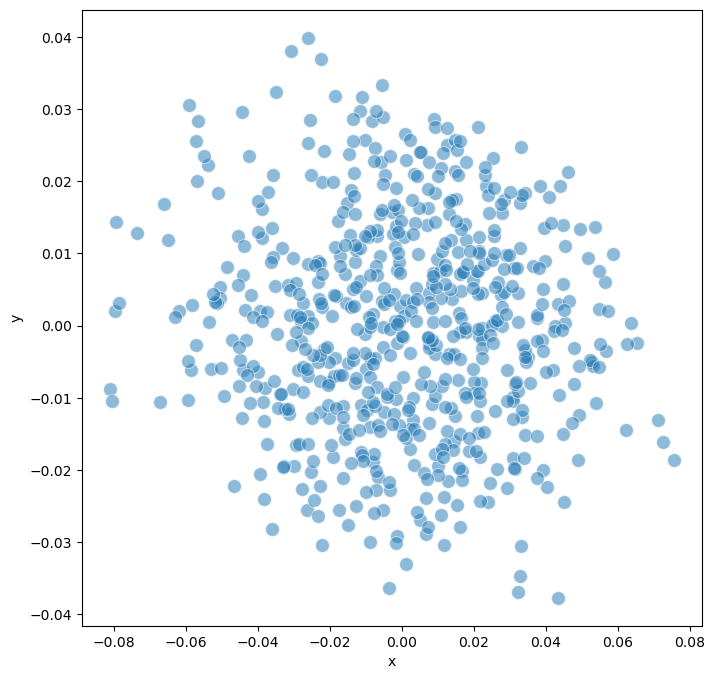

In [5]:
model.trajectory.calculate_distancematrix(mode = 'endpoint')
# Perform MDS (Multidimensional Scaling) for visualization
model.trajectory.calculate_MDS()
model.trajectory.plot_MDS(s = 100, fig_size = (8,8))

Calculating distance matrix for whole trajectory...


  0%|          | 0/616 [00:00<?, ?it/s]

Distance matrix calculated successfully.


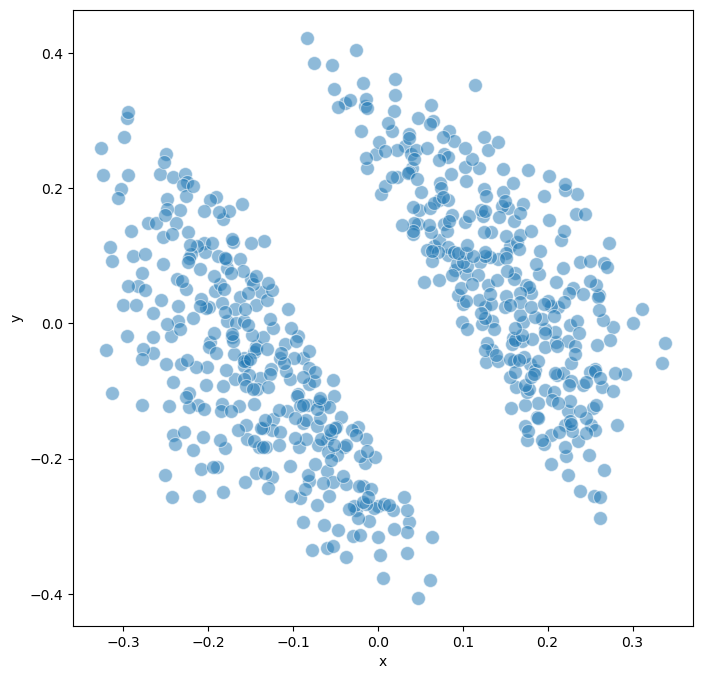

In [6]:
model.trajectory.calculate_distancematrix(mode = 'trajectory')
# Perform MDS (Multidimensional Scaling) for visualization
model.trajectory.calculate_MDS()
model.trajectory.plot_MDS(s = 100, fig_size = (8,8))

## Step 4: Model Clustering

Clustering reveals distinct groups within the model ensemble. In this example, we found 2 major clusters corresponding to different attractor groups, representing distinct cellular fate decisions.

In [7]:
model.trajectory.calculate_kmean_cluster(n_cluster = 2,
                              random_state = 0)

Calculated k-means clustering with 2 clusters.


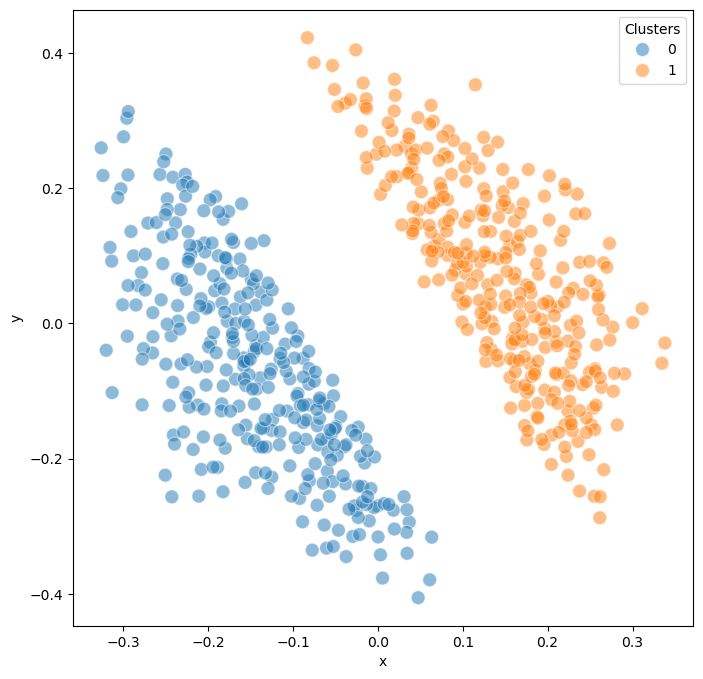

In [8]:
model.trajectory.plot_MDS(s = 100, fig_size = (8,8),plot_cluster = True)

## Step 5: Logic Function Analysis

This step implements the **logical function evaluation** component of AstroLogics:

- Converts Boolean equations to Disjunctive Normal Form (DNF)
- Creates feature matrices comparing logical rules across models
- Identifies **constant**, **varied**, and **marker** clauses

In [9]:
model.create_logic()
model.logic.model_logic
model.logic.create_flattend_logic_clause()

Loading models logics


  0%|          | 0/616 [00:00<?, ?it/s]

Concatenate results into matrix


  0%|          | 0/616 [00:00<?, ?it/s]

Logic object created
Flatten models logic clauses


  0%|          | 0/616 [00:00<?, ?it/s]

Concatenate results into matrix


  0%|          | 0/616 [00:00<?, ?it/s]

Flattend logic clause created


## Step 6 : Calculate statistic of Logic features (clauses)

In this steps, we have already featurized the logical equations into model logics or clauses. 

We can then integrate the clusters obtained from the trajectory analysis into the `.logic` and perform chi-square statistical test to categorize logic features (clauses) into 3 major groups

- Constatnt : core regulatory features that appears across BNs in the model ensemble
- Varied : Features that may differ between individual BNs but show no statistical significant
- Marker : Key discriminatory features that statistically distinguish between different model clusters.

We can define the p-value of the chi-square test using the function `pval_threshold`.


In [10]:
model.logic.map_model_clusters(model.trajectory.cluster_dict)
model.logic.calculate_logic_statistic(pval_threshold = 0.0001)

Model clusters mapped to logic clauses


The results of the analysis can be visualized in the form of Manhattan Plot shown below.

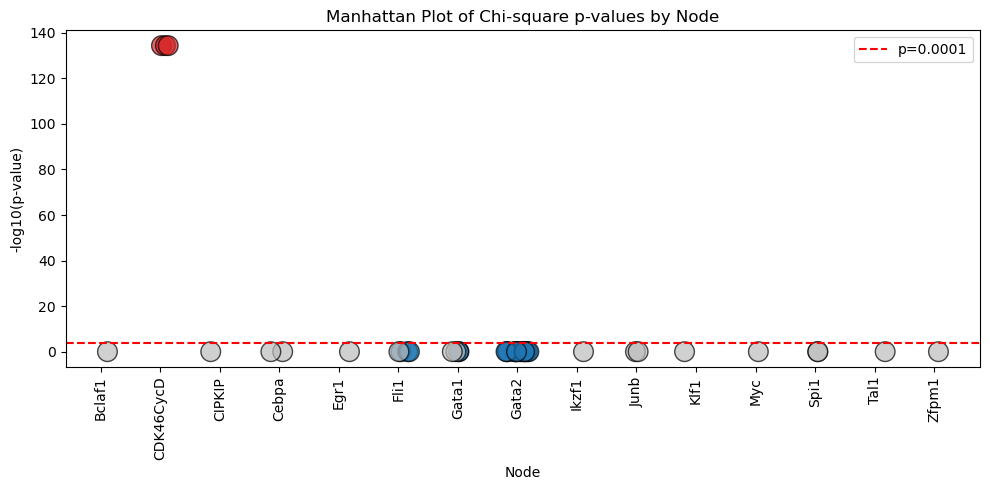

In [11]:
model.logic.plot_manhattan()

Or the results can be summarized into the barplot shown here

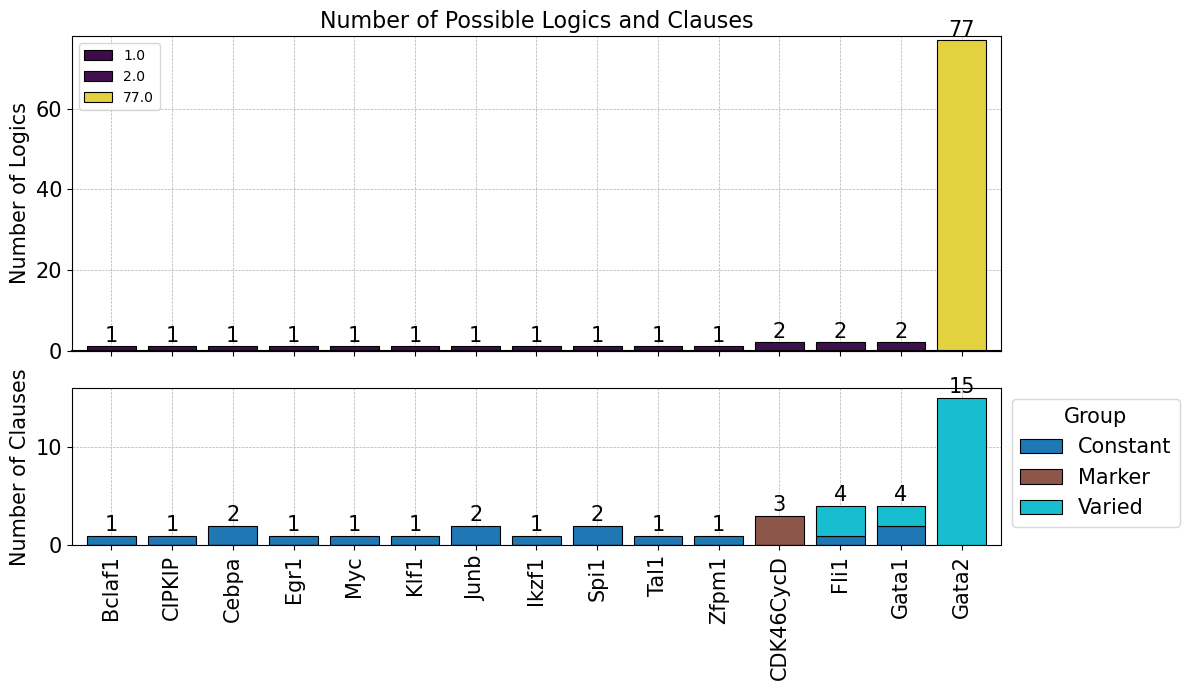

In [12]:
model.logic.plot_logicstat_summary()

## Step 7: Advanced Trajectory Analysis

These visualizations help identify:

- **Most variable nodes**: Components showing greatest differences between models
- **Critical regulators**: Nodes whose activity patterns distinguish model clusters
- **Temporal patterns**: How specific nodes behave over simulation time

In this first plot, we check what are the features that shows the highest variance in their dynamics accross simulation. We calculate the variance of node activation probabily of all BNs in the model ensemble across all timepoints and plotted using the heatmap.

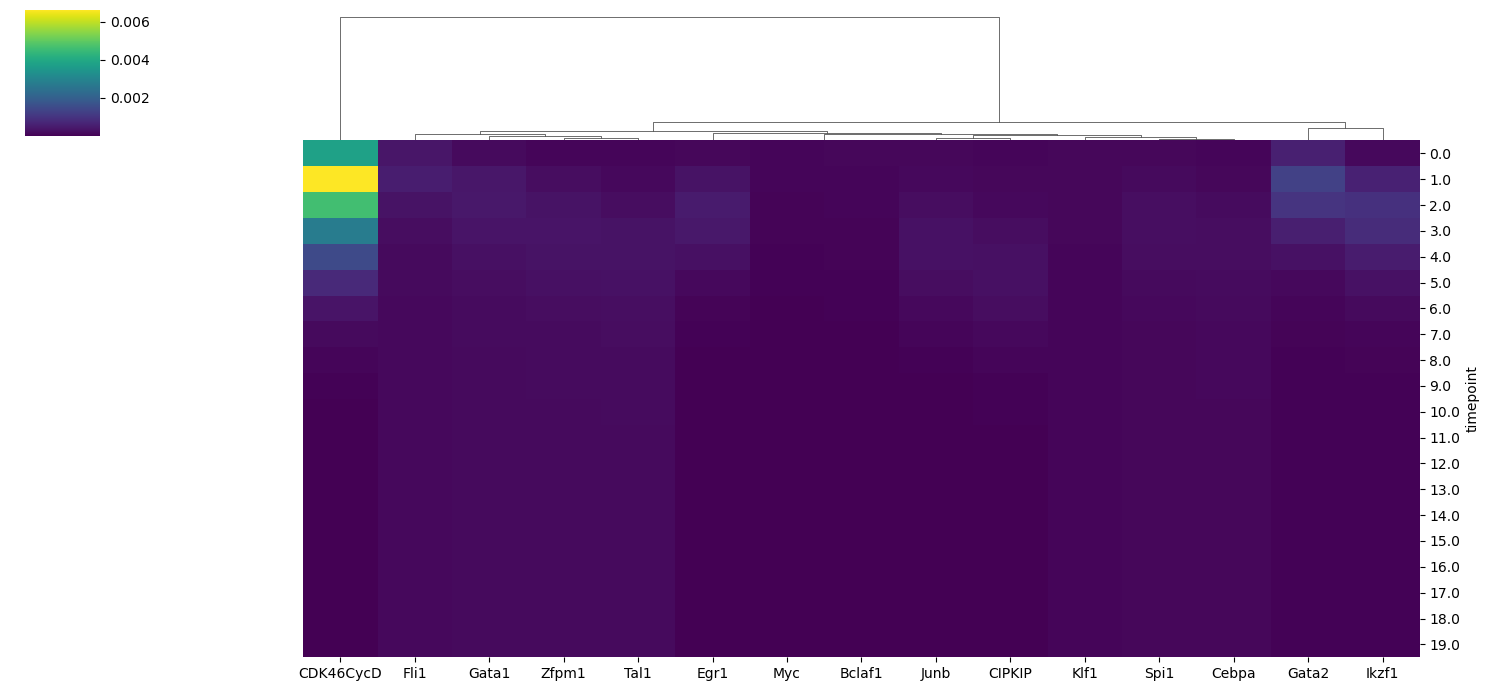

In [13]:
model.trajectory.plot_trajectory_variance()

We identify the key node of interest (CDK46CycD) which shows the highest variance along the timepoints. 
Finally, we could visualize the dynamics of this node between two identified clusters using the lineplot.

From this, we found that the dynamics of this node differ during the early timepoint of the simulation, while finally converge to 0 at the later timepoint.

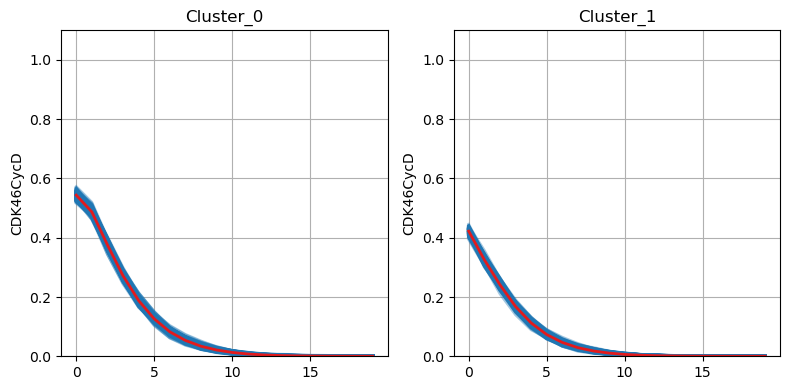

In [14]:
model.trajectory.plot_node_trajectory(node = ['CDK46CycD'])

## Step 8 : Logic Feature Heatmap

This analysis typically reveals that **Myt1L** is the key distinguishing node between clusters:

- **Cluster 0**: CDK46CycD is regulated by Bclaf1 & Myc
- **Cluster 1**: CDK46CycD is regulated by Bclaf1 | Myc

<Figure size 800x800 with 0 Axes>

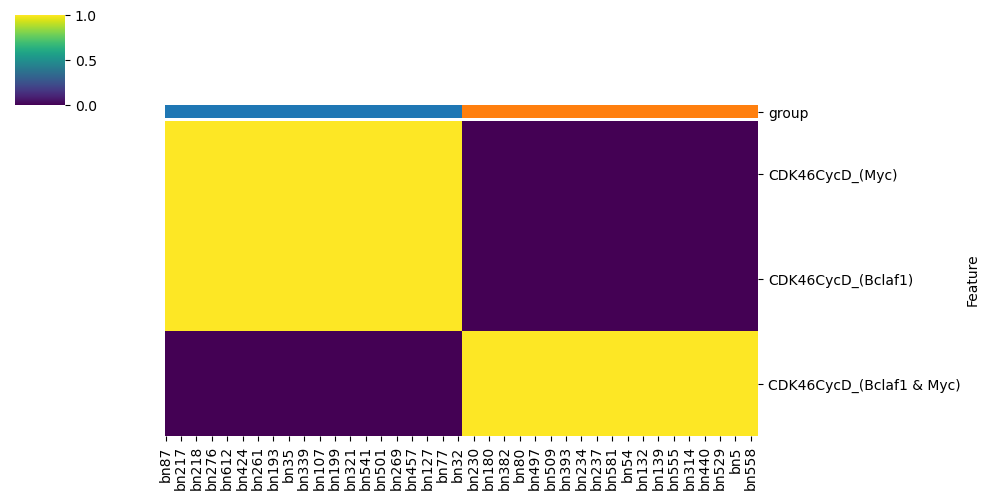

In [15]:
model.logic.plot_node_logic_heatmap(node = ['CDK46CycD'],
                                     fig_size = (8, 8))